##### Import Packages

In [1]:
import numpy as np 
import pandas as pd 
import xarray as xr 
import glob
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
from numpy import genfromtxt
import matplotlib.offsetbox as offsetbox
from cftime import num2date, DatetimeNoLeap
import matplotlib.colors as mcolors
import dask.array as da
import math
from geocat.viz import util as gvutil
from scipy.stats import norm
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import warnings
warnings.filterwarnings("ignore")

import climlab
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import warnings

from scipy.interpolate import griddata

def make_textbox(axes, string):

    box1 = offsetbox.TextArea(string,textprops=dict(fontsize=12,ha='left',fontweight='bold'))
    anchored_box = offsetbox.AnchoredOffsetbox(loc=3,
                                 child=box1, pad=0.2,
                                 frameon=False,
                                 bbox_to_anchor=(0,1),
                                 bbox_transform=axes.transAxes,
                                 borderpad=.2)
    axes.add_artist(anchored_box)
    
    return

#shift calendar 1 month ahead for correct grouping with .groupby 
cfcalendar_coords = num2date(np.arange(24*365), calendar='noleap', units='days since 0001-01-01') #generate noleap calendar for 12 years 

updated_cal_coords = []

for i in np.arange(len(cfcalendar_coords)):
    if i%365 in [0,32,59,90,120,152,182,212,243,273,304,334]: #indices for first day of each month 
        updated_cal_coords.append(cfcalendar_coords[i])


updated_cal_coords = np.array(updated_cal_coords)

textbox_labels = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n']

In [2]:
## Define regression function
def OLS(x,y):
    x_const = sm.add_constant(x)
    reg = sm.OLS(y,x_const).fit()

    coefs = reg.params[1]
    return coefs
    
## Define lagged regression function
def lagged_regress_spatialavg_tseries(x,y,lag): 

    # Input: x: dataArray; Nino3.4 differences between two experiments (e.g. lagreg-pdctl)
    # y: dataArray; Spatial-averaged time series (e.g. netAllSky, netCRE)
    # lag: int; lag 

    # Shifts regressor nino3.4 over time  (-ve lags move dataset forward )
    x_lag = x.shift(time=lag).transpose('time',...) # shift by lag on time-axis
    y_stack = y
    
    #align time coordinates for x and y (y_stack values will be dropped to adhere to x_lag coordinates)
    a_lag, b_stack = xr.align(x_lag.dropna(dim='time'),y_stack)
    
    # determine if reshaping x is necessary; make X, y into numpy arrays (helps sm.OLS run quicker) 
    if x_lag.ndim == 1:
        a_lag_np = a_lag.values.reshape(-1,1)
    else:
        a_lag_np = a_lag.values
    b_stack_np = b_stack.values
    
    # apply vectorized regression function at all [lat,lon] and format into xarray
    coefs = xr.apply_ufunc(OLS,a_lag_np,b_stack_np)
    coefs_xr = xr.DataArray(data=coefs)
    return coefs_xr

## Define function to loop lagged regression function
def time2lag(x, y, lag_list):
    y_lag = []
    for i in lag_list:
        y_lag.append(lagged_regress_spatialavg_tseries(x,y,i))

    return xr.concat(y_lag,dim='lag').assign_coords({'lag':lag_list})

def glob_mean(x):
    #take average of datapoints across lat and lon 
    globavg = x.mean('lat').mean('lon')
    return globavg

def monthly_mean(x):
    # average over each month across all years of simulation; returns one year of output and sorted by lags 
    # Input x: 
    monthly_avg = x.groupby('time.month').mean(dim='time')
    lags = np.append(monthly_avg.month.values[0:5],monthly_avg.month.values[5:]-12)
    monthly_avg['month'] = lags
    mon_avg_sorted = monthly_avg.rename({'month':'lag'}).sortby('lag', ascending=True)
    return mon_avg_sorted

def get_anomaly(x,detrend):
    clim = x.groupby('time.month').mean(dim='time')
    anom = x.groupby('time.month') - clim
    if detrend == 1:
        poly = anom.polyfit(dim='time', deg=1)
        fit = xr.polyval(anom['time'], poly.polyfit_coefficients)
        return anom - fit
    else:
        return anom

##### Load Data

In [3]:
precip_filepath = '/data/keeling/a/rytam2/a/class/a526/'
precip_ds = xr.open_mfdataset(precip_filepath+'*.nc')

# sst_lags_file = '/data/keeling/a/rytam2/a/ppe_input/ctl_bc/processed/tos/tos_SSTs_CMIP_PCMDI-AMIP-1-1-9_gn_lagreg_2000-03_2022-02_SeaIce_CMIP6_DECK_E3SM_1x1_2010_clim_c20190821.nc'
# sst_lags = xr.open_mfdataset(sst_lags_file,decode_times=False)
# nino34_sst_lag = glob_mean(sst_lags.sel(lat=slice(-5,5),lon=slice(190,240)))

pseudo_times_coords = pd.date_range(start="2003-01-01", end= "2022-12-31", freq='ME')

obs_filepath = '/data/keeling/a/rytam2/a/ppe_input/obs/nino3.4_tseries/'
nino34_obs = pd.read_csv(obs_filepath+'ersst5.nino.mth.91-20.ascii.csv')[['YR','MON','ANOM.3']]
nino34_sst_obs = pd.read_csv(obs_filepath+'ersst5.nino.mth.91-20.ascii.csv')[['YR','MON','NINO3.4']].to_xarray().isel(index=slice(636,876))
nino34_sst = nino34_sst_obs.assign_coords(index=pseudo_times_coords).drop_vars({'YR','MON'}).rename({'index':'time'})
nino34_anom = get_anomaly(nino34_sst['NINO3.4'],1)

#Load bootstrapped files 
perc_area_all=genfromtxt('/data/keeling/a/rytam2/classes/a526/perc_area_all.csv', delimiter=',')
perc_area_en=genfromtxt('/data/keeling/a/rytam2/classes/a526/perc_area_en.csv', delimiter=',')
perc_area_ln=genfromtxt('/data/keeling/a/rytam2/classes/a526/perc_area_ln.csv', delimiter=',')

In [4]:
## Define El Nino and La Nina years using Dec values > 1STD of nino3.4 as threshold
en = []
ln = []

for i in range(0,len(nino34_anom)):
    month = int(nino34_anom.time.dt.month[i])
    if month == 12 and nino34_anom[i] >= nino34_anom.std() and month not in en:
        en.append(int(nino34_anom.time.dt.year[i]))
    if month == 12 and nino34_anom[i].values <= -nino34_anom.std() and month not in ln:
        ln.append(int(nino34_anom[i].time.dt.year))
        
## Define backward and forward years for lagged composites
el_nino_yrs = np.concatenate([np.array(en),np.array(en)+1]).reshape(2,len(en))
la_nina_yrs = np.concatenate([np.array(ln),np.array(ln)+1]).reshape(2,len(ln))

nino34_anom_bylag = nino34_anom.groupby('time.month')
lag = np.arange(-6,6,1)
nino34_anom_bylag['month']=lag

##### Figure 1: Monthly Precipitation averaged across Years 2003-2022

In [5]:
mon_precip_ds = precip_ds.groupby('time.month').mean(dim='time')

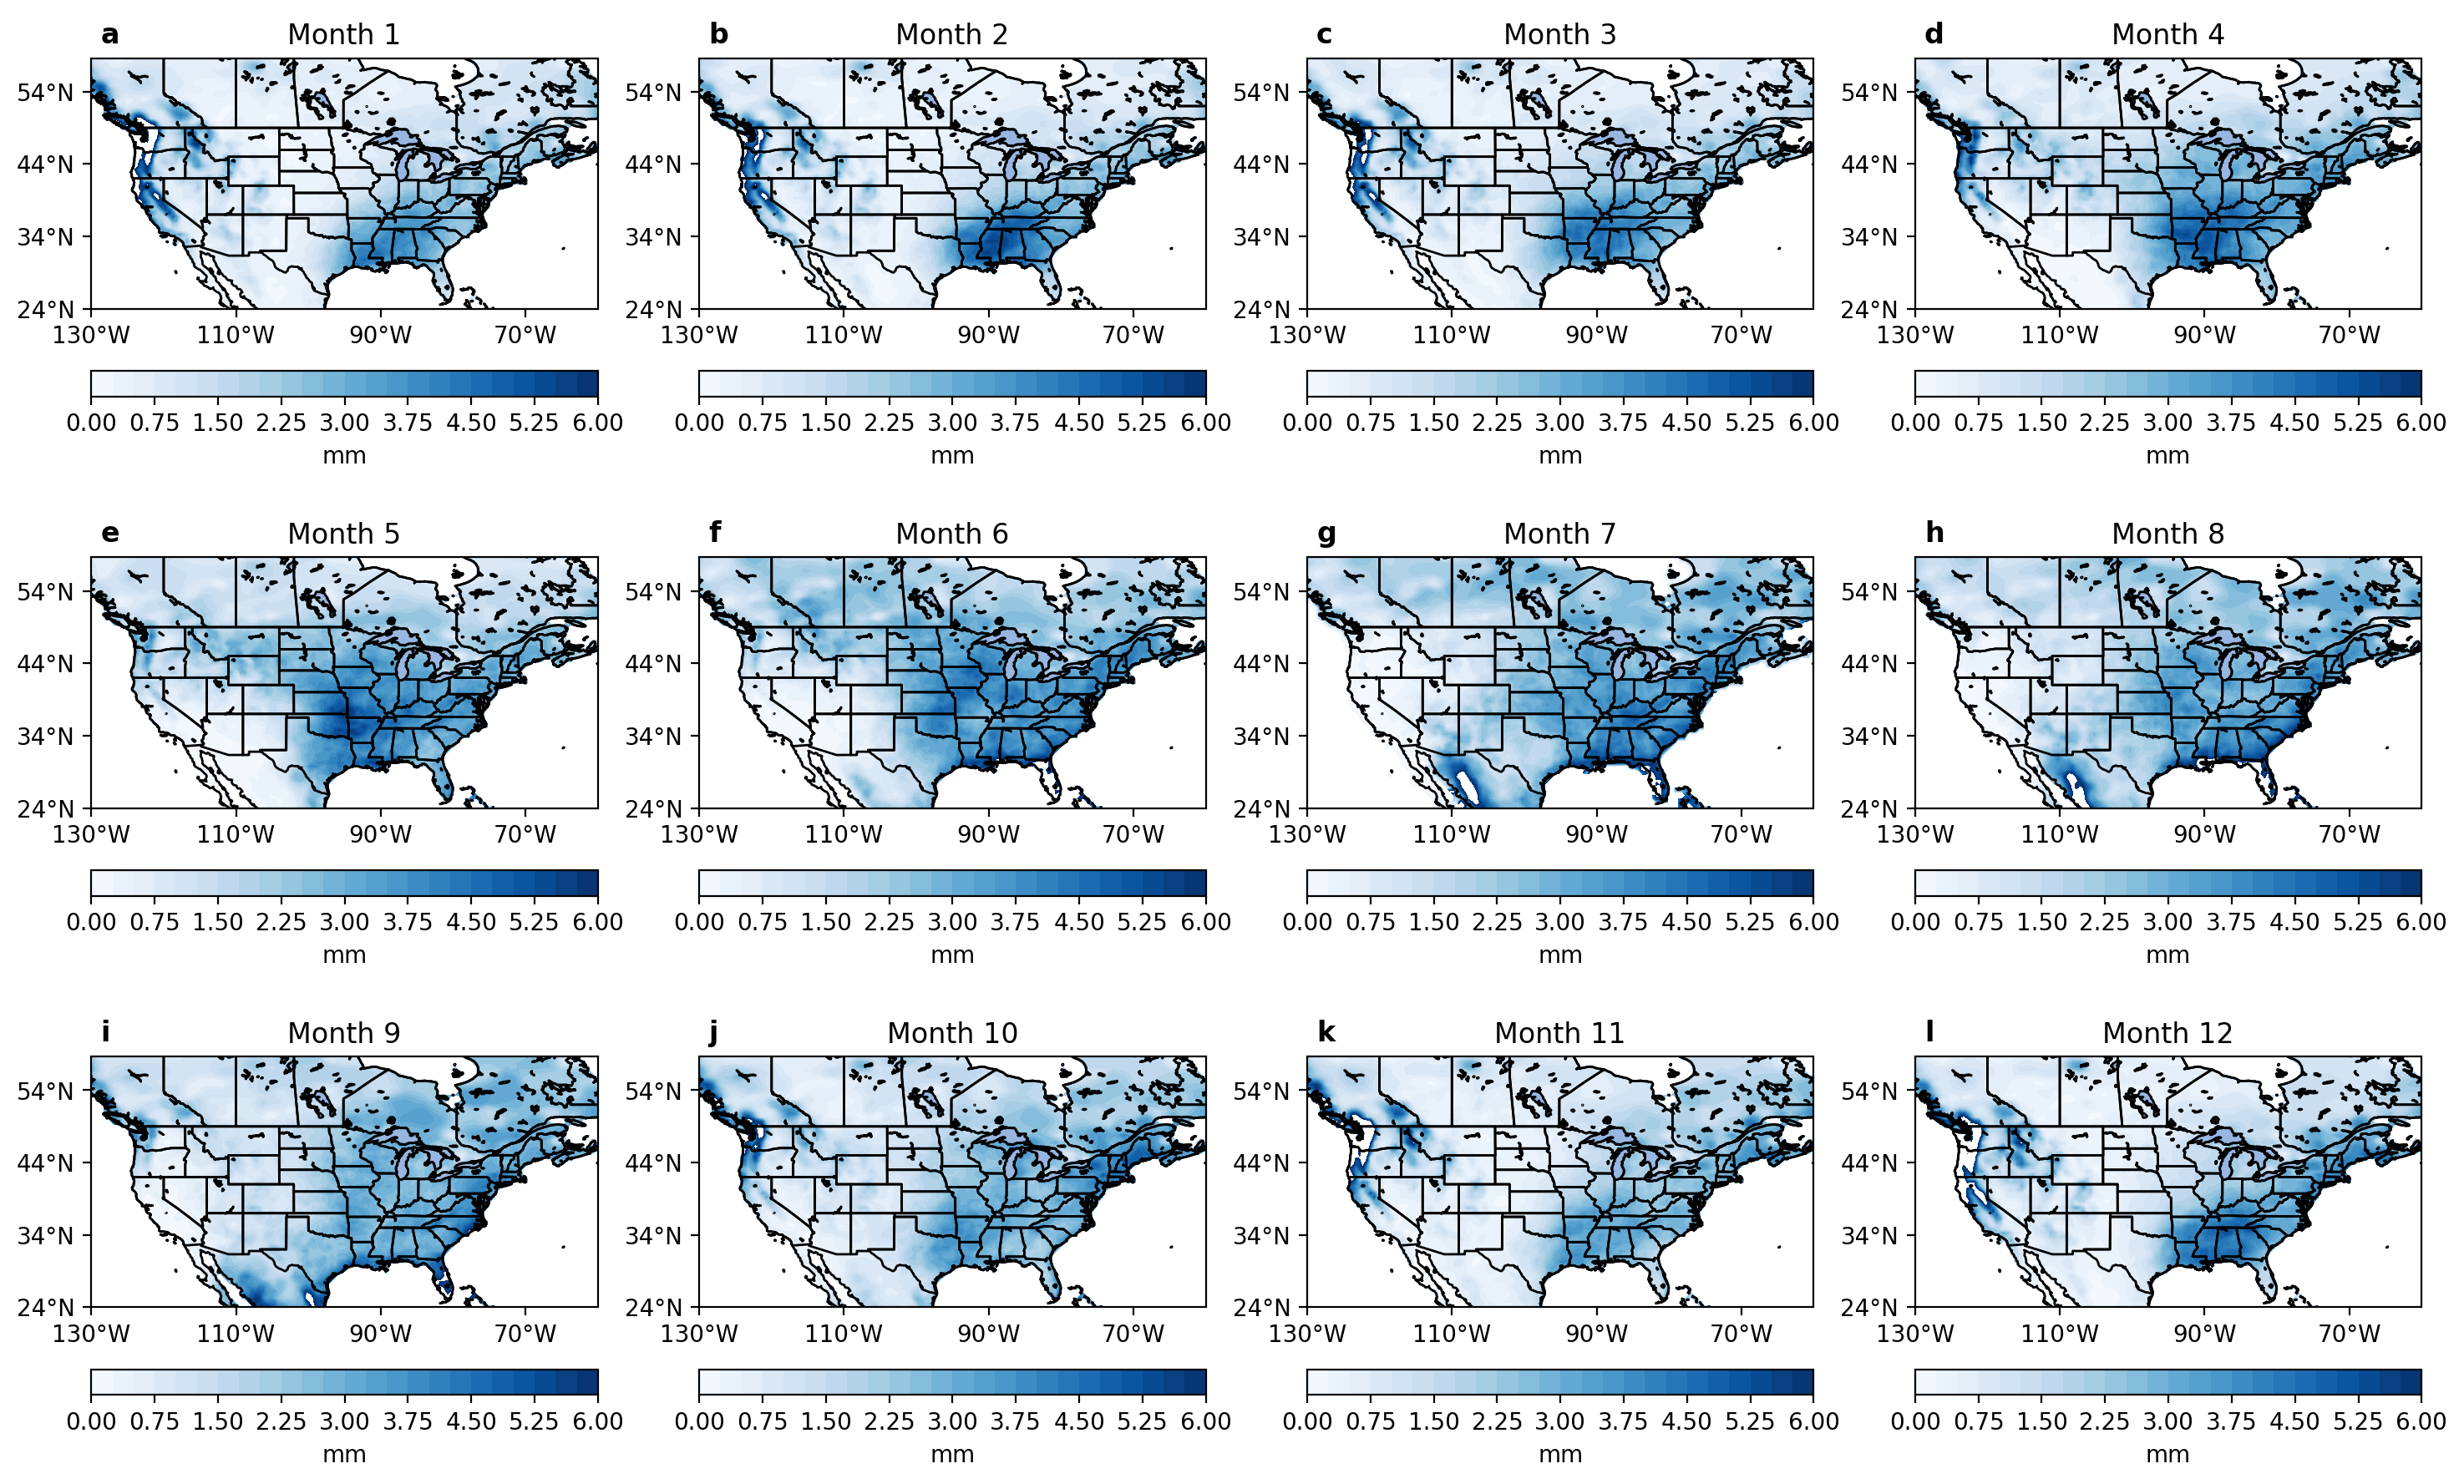

In [6]:
ds = mon_precip_ds
minval=0
maxval=6
cbaritvl=0.25
# cmap = mcolors.ListedColormap(ds.precip, 'precipitation')
# norm = mcolors.BoundaryNorm(clevs, cmap.N)

fig, ax = plt.subplots(3,4,figsize=(18,11),dpi=200,subplot_kw={'projection': ccrs.PlateCarree()})
levels = np.arange(minval,maxval+cbaritvl,cbaritvl)
normalize = mcolors.Normalize(vmin=minval, vmax=maxval)

row = 3
col = 4
for i in range(0,row): #row
    for j in range(0,col): #col 
        map = ax[i,j].contourf(ds.lon,ds.lat,ds.precip.isel(month=col*i+j),
                               cmap='Blues',norm=normalize,levels=levels)#,transform=ccrs.AlbersEqualArea())
        
        fig.colorbar(map, ax=ax[i,j],orientation='horizontal',extend='both',label='mm')
        
        ax[i,j].set_title('Month '+ str(ds.month.values[col*i+j]))
        ax[i,j].add_feature(cartopy.feature.LAKES, edgecolor='black')
        ax[i,j].coastlines()
        ax[i,j].add_feature(cfeature.STATES)
        
        ax[i,j].set_extent([-130, -60, 24, 53.5], crs=None)                     # Set map extend    
        gvutil.add_lat_lon_ticklabels(ax[i,j])                            # Add lat lon ticks    
        gvutil.set_axes_limits_and_ticks(ax[i,j], xticks=np.arange(-130, -60, 20),
                                             yticks=np.arange(24, 55.5, 10))
        
        make_textbox(ax[i,j],textbox_labels[col*i+j])    

plt.savefig('figures/figure1_NA_mon_precip.png',bbox_inches='tight')

##### Figure 2: Correlation Coefficients at each location with Nino3.4 Index in (a) 2003-2022, (b) El Nino and (c) La Nina years

In [6]:
djf_nino34_anom = nino34_anom.groupby('time.season')['DJF']
djf_precip_ds = precip_ds.precip.groupby('time.season')['DJF']
djf_precip_anom = get_anomaly(djf_precip_ds,1)
corrcoef = xr.corr(djf_nino34_anom,djf_precip_anom,dim='time')

# en_nino34_anom = nino34_anom.sel(time=(nino34_anom['time.year'].isin(el_nino_yrs))).sel(time=(nino34_anom['time.season']=='DJF'))
en_djf_nino34_anom = djf_nino34_anom.sel(time=(djf_nino34_anom['time.year'].isin(el_nino_yrs)))
en_djf_precip_ds = djf_precip_ds.sel(time=(djf_precip_ds['time.year'].isin(el_nino_yrs)))
en_djf_precip_anom = get_anomaly(en_djf_precip_ds,1)
en_corrcoef = xr.corr(en_djf_nino34_anom,en_djf_precip_anom,dim='time')

ln_djf_nino34_anom = djf_nino34_anom.sel(time=(djf_nino34_anom['time.year'].isin(la_nina_yrs)))
ln_djf_precip_ds = djf_precip_ds.sel(time=(djf_precip_ds['time.year'].isin(la_nina_yrs)))
ln_djf_precip_anom = get_anomaly(ln_djf_precip_ds,1)
ln_corrcoef = xr.corr(ln_djf_nino34_anom,ln_djf_precip_anom,dim='time')

In [75]:
2/np.sqrt(350)

0.10690449676496974

In [76]:
2/np.sqrt(3500)

0.033806170189140665

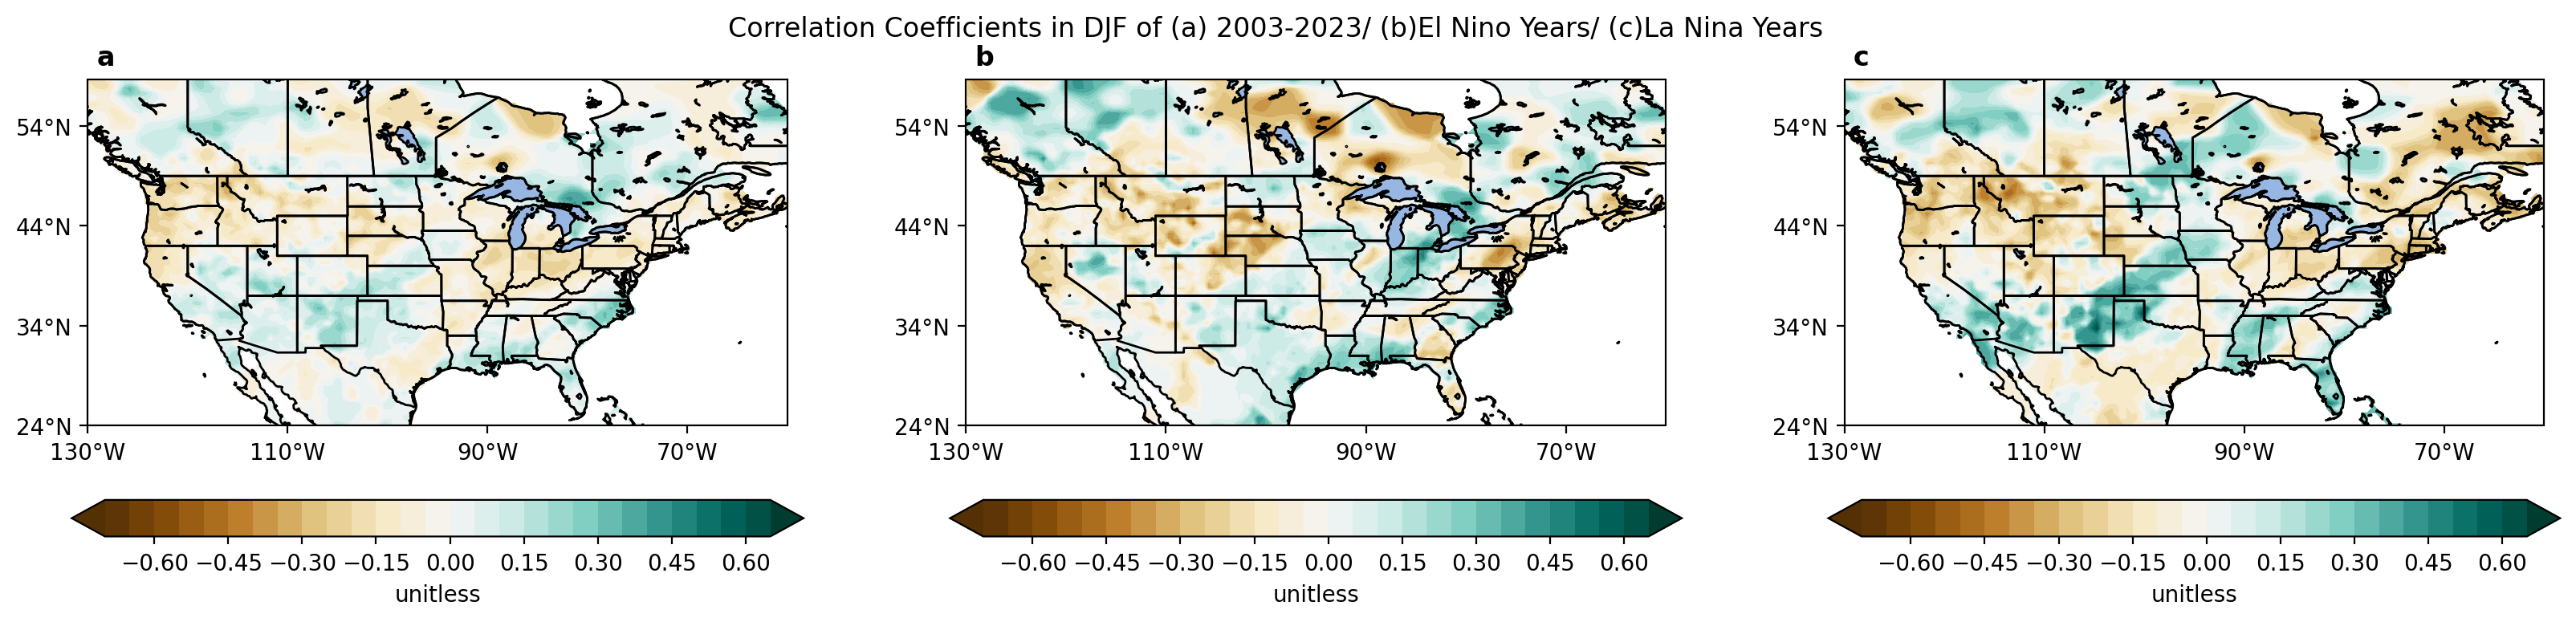

In [67]:
fig, ax = plt.subplots(1,3,figsize=(20,4),subplot_kw={'projection': ccrs.PlateCarree()},dpi=200)
levels = np.arange(-0.7,0.7,0.05)
normalize = mcolors.TwoSlopeNorm(vcenter=0, vmin=-0.7, vmax=0.7)


a = ax[0].contourf(corrcoef.lon,corrcoef.lat,(corrcoef),
                               cmap=plt.get_cmap('BrBG'),transform=ccrs.PlateCarree(),extend='both',norm=normalize,levels=levels)

b = ax[1].contourf(en_corrcoef.lon,en_corrcoef.lat,(en_corrcoef),
                               cmap=plt.get_cmap('BrBG'),transform=ccrs.PlateCarree(),extend='both',norm=normalize,levels=levels)

c = ax[2].contourf(ln_corrcoef.lon,ln_corrcoef.lat,(ln_corrcoef),
                               cmap=plt.get_cmap('BrBG'),transform=ccrs.PlateCarree(),extend='both',norm=normalize,levels=levels)

#divnorm=colors.TwoSlopeNorm(vmin=-5., vcenter=0., vmax=10)

map = [a,b,c]

for i in range(0,3):
        fig.colorbar(map[i], ax=ax[i],orientation='horizontal',extend='both',label='unitless')
        ax[i].add_feature(cartopy.feature.LAKES, edgecolor='black')
        ax[i].coastlines()
        ax[i].add_feature(cfeature.STATES)
        
        ax[i].set_extent([-130, -60, 24, 53.5], crs=None)                     # Set map extend    
        gvutil.add_lat_lon_ticklabels(ax[i])                            # Add lat lon ticks    
        gvutil.set_axes_limits_and_ticks(ax[i], xticks=np.arange(-130, -60, 20),
                                             yticks=np.arange(24, 55.5, 10))
        make_textbox(ax[i],textbox_labels[i])  

fig.suptitle('Correlation Coefficients in DJF of (a) 2003-2023/ (b)El Nino Years/ (c)La Nina Years');
plt.savefig('figures/figure2_corrcoef_DJF_nino34_precip.png',bbox_inches='tight')

##### Figure 3: Histogram of areas that would exceed 5% significance with randomly generated time series using Bootstrapping

generate random time series of the same length as NIno3.4 time series 

Generate arbitrary mean and variance from random to ensure independence and null hypothesis hold 
Compute correlation map 
Compute % of area that exceeds 5% significance 
Repeat process through bootstrapping 10000 times for mean and variance -> feed to time series 
 


##### Extra Code

fig, ax = plt.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()},dpi=200)
ax.contourf(area_frac.lon,area_frac.lat,(area_frac.where((sig_area_bool.lon>left) &\
                                      (sig_area_bool.lon<right)&\
                                     (sig_area_bool.lat<top)&\
                                     (sig_area_bool.lat>bottom))),transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.coastlines()
ax.add_feature(cfeature.STATES)

ax.set_extent([-130, -60, 24, 53.5], crs=None)    

area_frac = (np.cos(djf_precip_ds.lat*pi/180)).expand_dims(dim={"lon": djf_precip_ds.lon}).transpose('lat','lon').where((djf_precip_ds.lon>left) &\
                                      (djf_precip_ds.lon<right)&\
                                     (djf_precip_ds.lat<top)&\
                                     (djf_precip_ds.lat>bottom))
area_frac = area_frac/np.sum(area_frac) #constant at each location 

significance_threshold = (2/np.sqrt(len(djf_nino34_anom))) #constant

random_tseries = xr.DataArray(np.random.normal(mean,var,len(djf_nino34_anom)), coords={'time': djf_nino34_anom.time},dims=['time'])
corrcoef_bootstrap = xr.corr(random_tseries,djf_precip_ds,dim='time')
###### boolean that returns true for regoins those that passed significance test
sig_area_bool =  area_frac.where(np.abs(corrcoef_bootstrap)>significance_threshold)
###### Area in the US that passes the significance test 
tot_area = np.sum(sig_area_bool)
perc_area[i]=(tot_area.values *100)
print(perc_area[i])

# Calculations

##### Observation Percent Area with Significant Correlation

In [11]:
pi = np.pi
top = 49.3457868 # north lat
left = -124.7844079%360 # west long
right = -66.9513812%360 # east long
bottom =  24.7433195 # south lat

def perc_area_calc(nino34_anom_tseries,dataset):
    area_frac = (np.cos(dataset.lat*pi/180)).expand_dims(dim={"lon": dataset.lon}).transpose('lat','lon').where((dataset.lon>left) &\
                                                                                                              (dataset.lon<right)&\
                                                                                                             (dataset.lat<top)&\
                                                                                                             (dataset.lat>bottom))
    area_frac = area_frac/np.sum(area_frac) #constant at each location 
    significance_threshold = (2/np.sqrt(len(nino34_anom_tseries))) #constant
    
    corrcoef = xr.corr(nino34_anom_tseries,dataset,dim='time')
    # boolean that returns true for regoins those that passed significance test
    sig_area_bool =  area_frac.where(np.abs(corrcoef)>significance_threshold)
    # Area in the US that passes the significance test 
    tot_area = np.sum(sig_area_bool)
    perc_area = tot_area.values *100
    return significance_threshold,perc_area

In [12]:
thres_all, obs_perc_area_all = perc_area_calc(djf_nino34_anom,djf_precip_ds)
thres_en, obs_perc_area_en = perc_area_calc(en_djf_nino34_anom,en_djf_precip_ds)
thres_ln, obs_perc_area_ln =perc_area_calc(ln_djf_nino34_anom,ln_djf_precip_ds)

##### Bootstraps

In [10]:
def bootstrap(nino34_anom_tseries,dataset, ntrials,perc_area):
    area_frac = (np.cos(dataset.lat*pi/180)).expand_dims(dim={"lon": dataset.lon}).transpose('lat','lon').where((dataset.lon>left) &\
                                                                                                              (dataset.lon<right)&\
                                                                                                             (dataset.lat<top)&\
                                                                                                             (dataset.lat>bottom))
    area_frac = area_frac/np.sum(area_frac) #constant at each location 
    significance_threshold = (2/np.sqrt(len(nino34_anom_tseries))) #constant
    
    for i in np.arange(0,ntrials,1):
        random_tseries = xr.DataArray(np.random.normal(mean,var,len(nino34_anom_tseries)), coords={'time': nino34_anom_tseries.time},dims=['time'])
        corrcoef_bootstrap = xr.corr(random_tseries,dataset,dim='time')
        # boolean that returns true for regoins those that passed significance test
        sig_area_bool =  area_frac.where(np.abs(corrcoef_bootstrap)>significance_threshold)
        # Area in the US that passes the significance test 
        tot_area = np.sum(sig_area_bool)
        perc_area.append(tot_area.values *100)
        print(i,perc_area[i])

In [11]:
# Constants for Bootstrap 
ntrials = 10000
# perc_area = np.empty(ntrials)
# perc_area[:] = np.nan
perc_area_all = []
perc_area_en = []
perc_area_ln = []

mean = 0
var = 1 

In [19]:
bootstrap(djf_nino34_anom,djf_precip_ds,ntrials,perc_area_all)

0 6.6918060183525085
1 4.8803746700286865
2 2.9774583876132965
3 5.489519611001015
4 2.2146545350551605
5 2.0472975447773933
6 1.8530407920479774
7 2.907315269112587
8 2.7924854308366776
9 1.9942648708820343
10 2.9446054250001907
11 5.440480262041092
12 2.933231182396412
13 2.5851018726825714
14 1.4931261539459229
15 1.5101817436516285
16 3.051299601793289
17 6.17193765938282
18 4.1007887572050095
19 0.5003632046282291
20 1.2791117653250694
21 0.8991592563688755
22 2.4178098887205124
23 6.939523667097092
24 0.905547384172678
25 7.832662016153336
26 6.06098510324955
27 2.754528634250164
28 2.49856635928154
29 1.5606017783284187
30 3.095680847764015
31 4.687444120645523
32 1.5005605295300484
33 2.365952543914318
34 2.1646469831466675
35 3.040611930191517
36 2.7876926586031914
37 2.3618370294570923
38 5.498350411653519
39 1.195744052529335
40 2.971773222088814
41 1.33831687271595
42 1.3495128601789474
43 1.743185706436634
44 1.07056125998497
45 1.8173126503825188
46 2.077849581837654
47 3

In [23]:
bootstrap(en_djf_nino34_anom,en_djf_precip_ds,ntrials,perc_area_en)

0 1.711743138730526
1 0.9984655305743217
2 1.1533185839653015
3 1.3265522196888924
4 8.843684196472168
5 3.1595617532730103
6 1.0526124387979507
7 2.427554503083229
8 2.2177837789058685
9 1.5181596390902996
10 6.04226179420948
11 0.8924528025090694
12 1.3374979607760906
13 1.9005708396434784
14 3.118237480521202
15 1.0688929818570614
16 6.215830147266388
17 4.498465359210968
18 2.586451545357704
19 1.8075395375490189
20 11.892703175544739
21 2.6197362691164017
22 3.2449711114168167
23 1.0849989019334316
24 1.2108422815799713
25 7.200591266155243
26 1.2901388108730316
27 9.906398504972458
28 6.477923691272736
29 3.3094555139541626
30 2.8035489842295647
31 2.9646486043930054
32 4.418826475739479
33 3.628518432378769
34 4.221880808472633
35 5.972586944699287
36 0.8939145132899284
37 1.940704695880413
38 7.7847979962825775
39 2.024754323065281
40 4.143936187028885
41 0.9822677820920944
42 6.031513214111328
43 2.128271572291851
44 3.0647723004221916
45 0.9628496132791042
46 0.91710900887846

In [24]:
bootstrap(ln_djf_nino34_anom,ln_djf_precip_ds,ntrials,perc_area_ln)

0 1.2799850665032864
1 0.9650110267102718
2 3.947080671787262
3 2.9981568455696106
4 5.333930626511574
5 3.8192715495824814
6 2.354792319238186
7 3.4058891236782074
8 1.5817699953913689
9 4.589365795254707
10 1.657576858997345
11 4.923520237207413
12 3.8024861365556717
13 2.2336848080158234
14 6.358737498521805
15 6.297531723976135
16 2.5107380002737045
17 4.606269299983978
18 4.7382548451423645
19 3.068757988512516
20 1.2884432449936867
21 2.6671752333641052
22 2.4649731814861298
23 5.116470158100128
24 1.494517456740141
25 3.7610039114952087
26 1.2105991132557392
27 1.7506087198853493
28 1.6007231548428535
29 1.414364855736494
30 0.9825556538999081
31 6.5292976796627045
32 3.4050077199935913
33 0.5736387334764004
34 1.3827931135892868
35 0.5883099511265755
36 4.6851497143507
37 5.640548840165138
38 4.159997031092644
39 2.3887615650892258
40 1.2187553569674492
41 0.23852188605815172
42 0.8148925378918648
43 1.0150222107768059
44 4.448198527097702
45 1.6319496557116508
46 1.19070764631

In [ ]:
np.savetxt("perc_area_all.csv", np.array(perc_area_all), delimiter=",")
np.savetxt("perc_area_ln.csv", np.array(perc_area_ln), delimiter=",")
np.savetxt("perc_area_en.csv", np.array(perc_area_en), delimiter=",")

##### calculations

In [13]:
quantile_all = np.percentile(perc_area_all, 95)
quantile_en = np.percentile(perc_area_en, 95)
quantile_ln = np.percentile(perc_area_ln, 95)

In [41]:
thres_en

0.3849001794597505

In [18]:
quantile_ln

7.699233070015907

# Figures

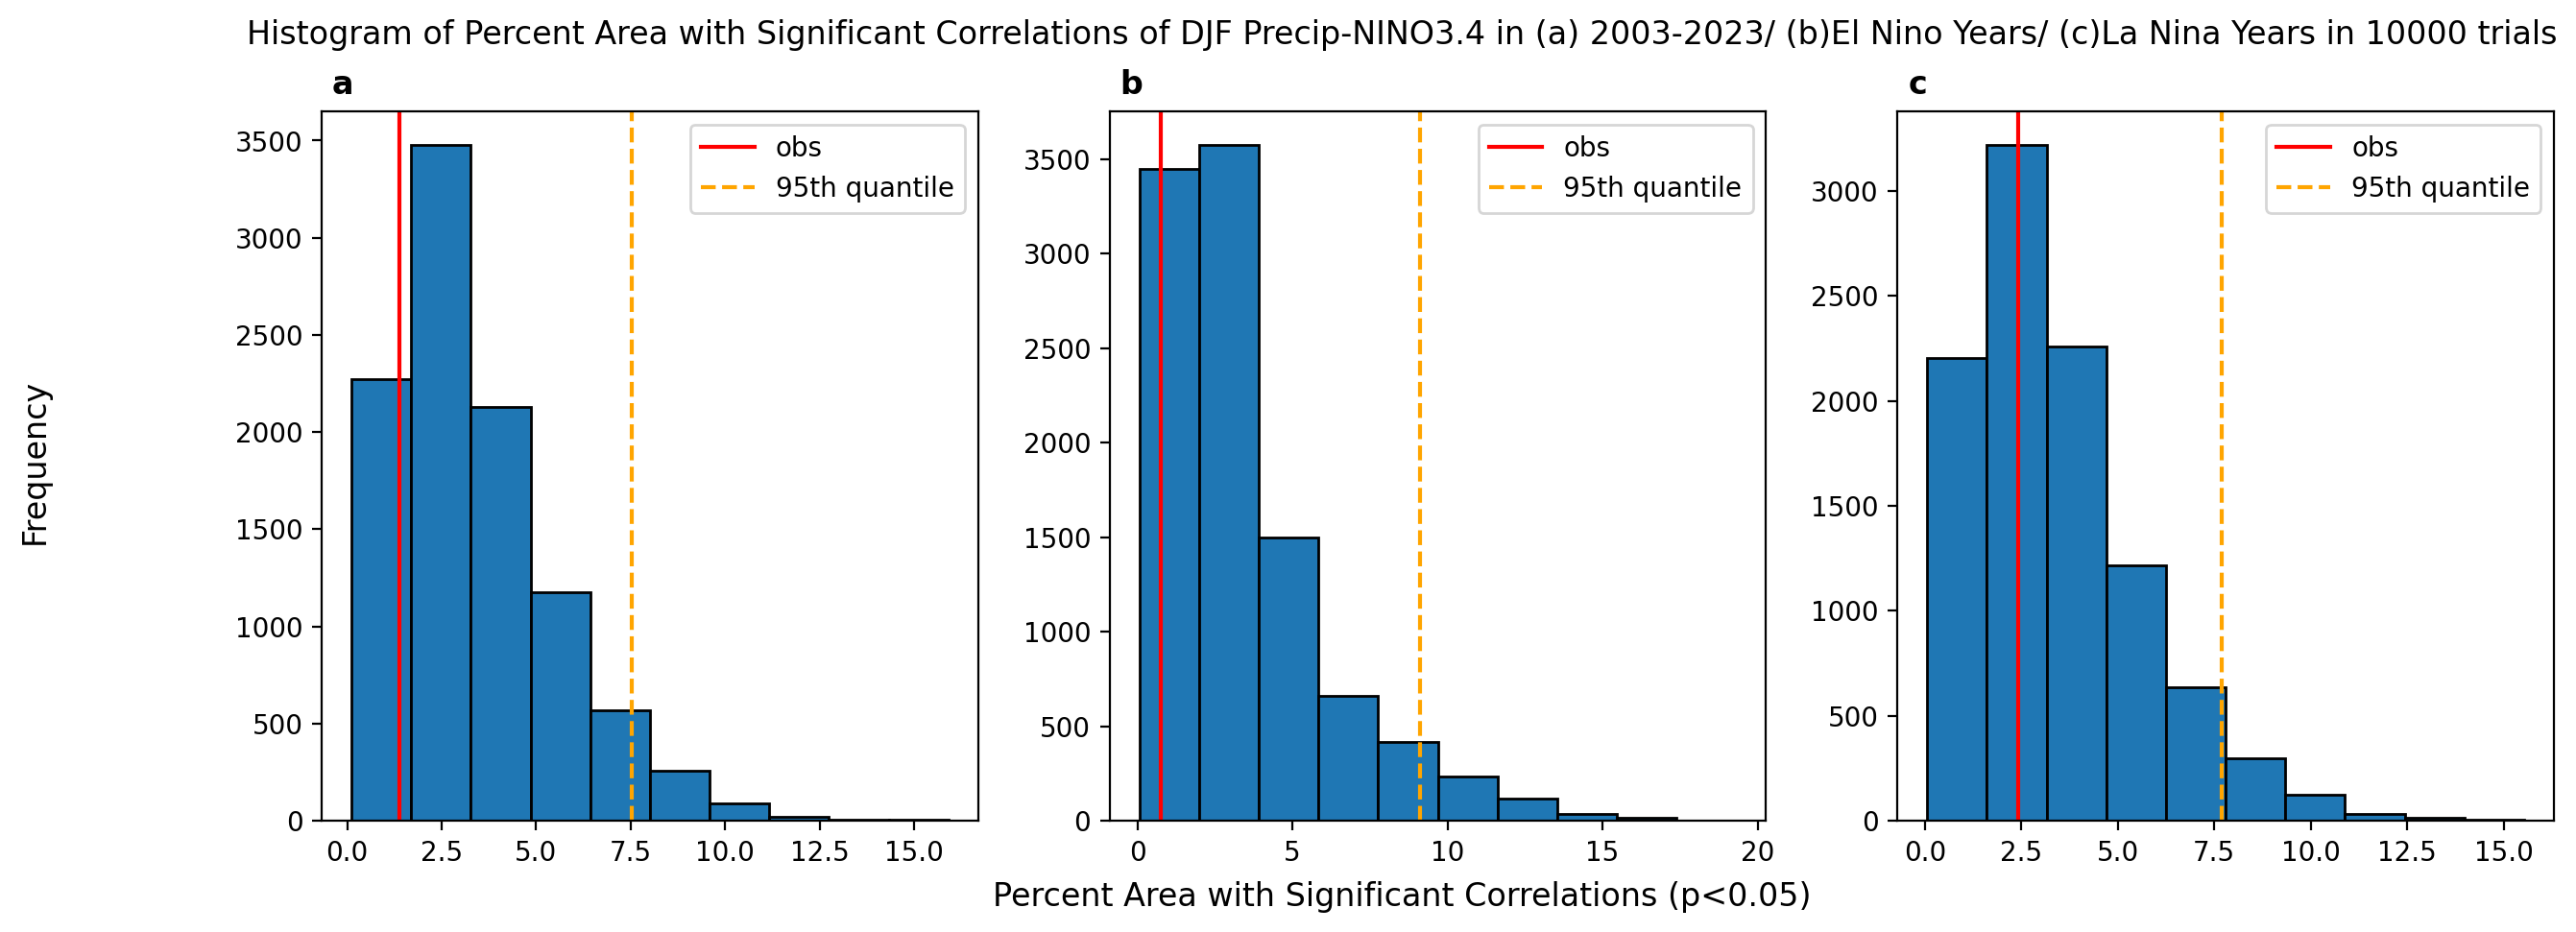

In [68]:
fig, ax = plt.subplots(1,3,figsize=(15,4.8),dpi=200)

a = ax[0].hist(perc_area_all, edgecolor='black')
ax[0].axvline(x = obs_perc_area_all, color = 'red', label = 'obs')
ax[0].axvline(x = quantile_all, color = 'orange',linestyle='dashed', label = '95th quantile')
ax[0].legend()

b = ax[1].hist(perc_area_en, edgecolor='black')
ax[1].axvline(x = obs_perc_area_en, color = 'red', label = 'obs')
ax[1].axvline(x = quantile_en, color = 'orange',linestyle='dashed', label = '95th quantile')
ax[1].legend()

c = ax[2].hist(perc_area_ln, edgecolor='black')
ax[2].axvline(x = obs_perc_area_ln, color = 'red', label = 'obs')
ax[2].axvline(x = quantile_ln, color = 'orange',linestyle='dashed', label = '95th quantile')
ax[2].legend()

#divnorm=colors.TwoSlopeNorm(vmin=-5., vcenter=0., vmax=10)

map = [a,b,c]

for i in range(0,3):
    make_textbox(ax[i],textbox_labels[i])  
    
fig.supylabel('Frequency')
fig.supxlabel('Percent Area with Significant Correlations (p<0.05)')
fig.suptitle('Histogram of Percent Area with Significant Correlations of DJF Precip-NINO3.4 in (a) 2003-2023/ (b)El Nino Years/ (c)La Nina Years in 10000 trials');
plt.savefig('figures/figure3_hist_precentareawithsignificantcorr_precip_.png',bbox_inches='tight')